# Import Library

In [1]:
# Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import pickle
from collections import Counter
import joblib
from tensorflow.keras.models import load_model

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from gensim.models import FastText, KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer,roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_validate

# Hyperparameter Tuning
from keras_tuner import RandomSearch

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt


# Load File

In [ ]:
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
df = pd.read_csv(file_path)

# ----------------------------------------------------------------------------------------------------------------------
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=10000)
# textData = tfidf.fit_transform(df['text'])
# x = textData
# y = df['label']

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# OR -----------------------------------------------------------------------------------------------------

X = df['text'].astype(str).values  
Y = df['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000  # vocab size
max_len = 100  # the max length of the each sentences 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) 
X_seq = tokenizer.texts_to_sequences(X) 
X_padding = pad_sequences(X_seq, maxlen=max_len) 

# ----------------------------------------------------------------------------------------------------------------------
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X_padding, Y, test_size=0.3, stratify=Y, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(x_train, y_train)

print("Class distribution after resampling:", Counter(y_train_resampled))



Class distribution after resampling: Counter({0: 18063, 1: 18063})


# Machine Learning

## Learning Curve (Base model)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import joblib

model = joblib.load(r"Saved Model Hate/XGB/1_XGB_HP.pkl")  # .pkl

train_sizes, train_scores, test_scores = learning_curve(
    model, x_train_resampled, y_train_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')

for i, txt in enumerate(train_scores_mean):
    plt.text(train_sizes[i], train_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='o')

for i, txt in enumerate(test_scores_mean):
    plt.text(train_sizes[i], test_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.show()


## precision_recall_curve

In [5]:
model = joblib.load(r"Saved Model Hate/XGB/1_XGB_HP.pkl")  # .pkl

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(y_test) / len(y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Confusion Matrix

In [ ]:
model = joblib.load(r"Saved Model Hate/XGB/1_XGB_HP_best_estimator_.pkl")  # .pkl

y_test_pred = model.predict(x_test)

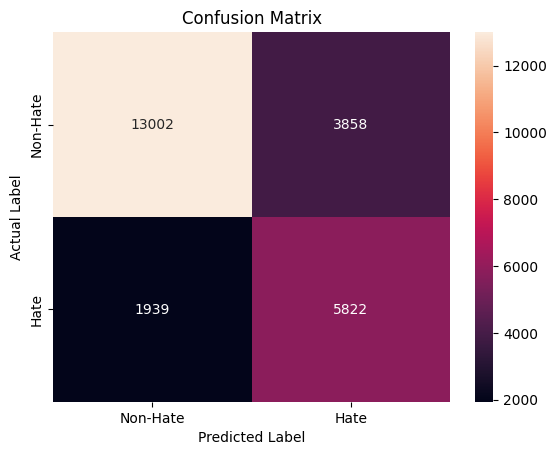

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Evaluate Model (ML)

In [ ]:
model = joblib.load(r"Saved Model Hate/XGB/1_XGB_HP_best_estimator_.pkl")  # .pkl

train_predictions = model.predict(x_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, train_predictions)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_predictions = model.predict(x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

y_pred_prob = model.predict_proba(x_test)[:, 1]

y_pred = (y_pred_prob > 0.5).astype(int)

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

# 计算 Precision 和 Recall
precision = precision_score(y_test, y_pred, average='binary')  
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## Best Hyperparameter (XGB)

In [ ]:
import joblib
import pandas as pd

random_search_results = joblib.load(r"Saved Model Hate\XGB\1_XGB_HP.pkl")

print("="*100)
print("✅ RandomizedSearchCV Object Type:", type(random_search_results))
print("="*100)

# Display best parameters
print("Best Parameters Found:")
for key, value in random_search_results.best_params_.items():
    print(f"   {key:<20}: {value}")

print("\n🏆 Best Score (Weighted F1): {:.4f}".format(random_search_results.best_score_))

# Convert results to a DataFrame
results_df = pd.DataFrame(random_search_results.cv_results_)

print("\n📈 Top Hyperparameter Combinations:")
print(results_df[[
    'param_max_depth', 'param_learning_rate', 'param_n_estimators', 
    'param_reg_lambda', 'param_reg_alpha', 'mean_test_score'
]].sort_values(by='mean_test_score', ascending=False).head(10))  # Show top 10 results

best_xgb_model = random_search_results.best_estimator_
print("\n🔍 Best Model Details:\n", best_xgb_model)


✅ RandomizedSearchCV Object Type: <class 'sklearn.model_selection._search.RandomizedSearchCV'>
Best Parameters Found:
   subsample           : 0.8
   reg_lambda          : 10
   reg_alpha           : 5
   n_estimators        : 200
   min_child_weight    : 3
   max_depth           : 20
   learning_rate       : 0.3
   gamma               : 0.1
   colsample_bytree    : 0.7

🏆 Best Score (Weighted F1): 0.7510

📈 Top Hyperparameter Combinations:
   param_max_depth  param_learning_rate  param_n_estimators  param_reg_lambda  \
6               20                  0.3                 200                10   
7               15                  0.3                 100                15   
1               20                  0.3                 200                 5   
5               20                  0.3                 100                20   
8               10                  0.2                 150                15   
4                8                  0.1                 100          

# Deep Learning Model

## Get Best Hyperparameter (.PKL) 

In [ ]:
import pickle

with open(r"Saved Model Hate/LSTM/2_LSTM_HPTuner_Initialized_0.2.pkl", 'rb') as f:
    tuner = pickle.load(f)

print("=" * 100)
print("✅ Object Type:", type(tuner))
print("=" * 100)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
print("-" * 40)
for param, value in best_hps.values.items():
    print(f"{param:20} : {value}")
print("-" * 40)

try:
    best_score = tuner.oracle.get_best_trials(num_trials=1)[0].score
    print("\n🏆 Best Score (Weighted F1): {:.4f}".format(best_score))
except AttributeError:
    print("\n⚠️ Best Score not found. Ensure the tuner has completed trials.")


In [ ]:
import pickle

# Load the saved tuner
with open(r"Saved Model Hate/LSTM/2_LSTM_HPTuner_Initialized_0.2.pkl", 'rb') as f:
    tuner = pickle.load(f)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

param_names = {
    "LSTM_layer_1": "Bi-LSTM_layer_1",
    "LSTM_layer_2": "Bi-LSTM_layer_2",
    "LSTM_layer_3": "Bi-LSTM_layer_3",
}

print("\nBest Hyperparameters:")
print("-" * 40)
for param, value in best_hps.values.items():
    display_name = param_names.get(param, param)  # Rename if in dictionary
    print(f"{display_name:20} : {value}")
print("-" * 40)


## Each Trial Hyperparameter

In [ ]:
import json

file_path = r".\my_dir_MTL\MTL_Hate_Emotion_2\trial_0000\trial.json"

with open(file_path, "r") as f:
    config = json.load(f)

hyperparams = config["hyperparameters"]["values"]
metrics = config["metrics"]["metrics"]

print("📌 Hyperparameters\n")
for key, value in hyperparams.items():
    print(f"- {key}: {value}")

print("\n📊 Training Metrics\n")
print(f"- Training Accuracy: {metrics['accuracy']['observations'][0]['value'][0]:.4f}")
print(f"- Training Loss: {metrics['loss']['observations'][0]['value'][0]:.4f}")
print(f"- Validation Accuracy: {metrics['val_accuracy']['observations'][0]['value'][0]:.4f}")
print(f"- Validation Loss: {metrics['val_loss']['observations'][0]['value'][0]:.4f}")

print(f"\n🏆 Best Validation Accuracy: {config['score']:.4f}")
print(f"📌 Best Step: {config['best_step']}")
print(f"✅ Status: {config['status']}")



## Evaluate Model (facol loss)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable


@register_keras_serializable(package="CustomLoss")
def focal_loss_1(y_true, y_pred, gamma=2.0, alpha=0.53):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/GRU/6_GRU_Hate_FineTuning_Model.keras",
    custom_objects={'focal_loss_1': focal_loss_1}
)
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Normal Evaluate

In [ ]:

model = load_model(r"Saved Model Hate/LSTM/7_LSTM_FastText_FineTune_Model.h5")

train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Learning Curve

In [ ]:
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

history = joblib.load(r"Saved Model Hate/CNN_LSTM/1_CNN-LSTM_HP_History.pkl")

accuracy = history.get('accuracy', [])
val_acc = history.get('val_accuracy', [])
loss = history.get('loss', [])
val_loss = history.get('val_loss', [])

epochs = range(1, len(accuracy) + 1)

sns.set_style("white") 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('HP Tuning Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(epochs) 

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('HP Tuning Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(epochs)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) - 0.04, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) - 0.004, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    

plt.tight_layout()
plt.show()



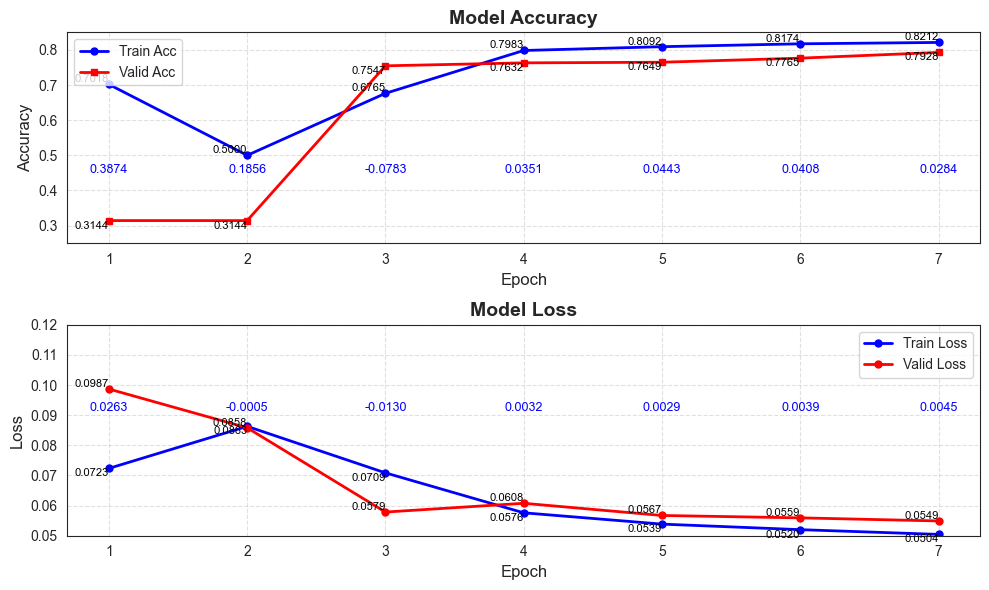

In [ ]:
import matplotlib.pyplot as plt
import joblib

history = joblib.load(r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_History.pkl")

accuracy = history.get('accuracy', []) [:7]
val_acc = history.get('val_accuracy', []) [:7]
loss = history.get('loss', []) [:7]
val_loss = history.get('val_loss', []) [:7]

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.06, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.04, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
axes[0].set_ylim(0.25, 0.85)
axes[1].set_ylim(0.05, 0.12)

plt.tight_layout()
plt.show()


## roc_curve

In [8]:
model = load_model(r"Saved Model Hate/LSTM/6_LSTM_FastText_FineTune_lowerLR_Model.h5")

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

770/770 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step



📌 ROC AUC: 0.8516


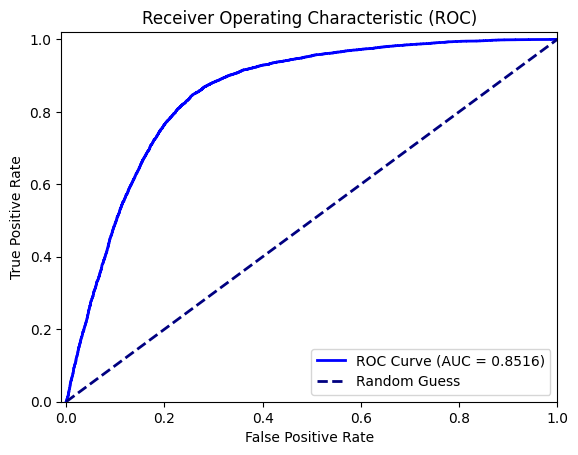

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## precision_recall_curve

In [ ]:
model = load_model(r"Saved Model Hate/GRU/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras")

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

770/770 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step



📌 Precision-Recall AUC: 0.6705


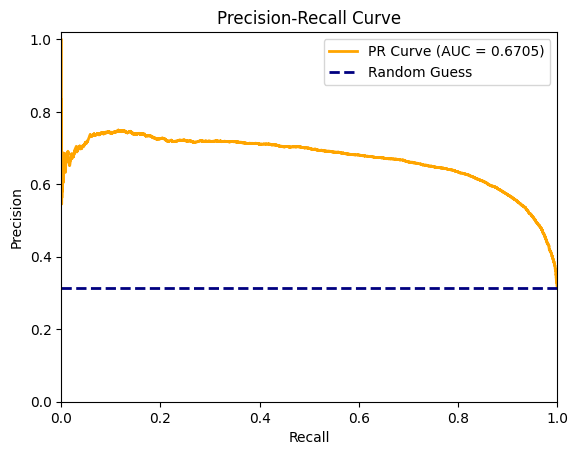

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(y_test) / len(y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## confusion_matrix

In [ ]:
model = load_model(r"Saved Model Hate/GRU/6_GRU_Hate_FineTuning_Model.keras")

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.9"),
            xticklabels=['0: Non-Hate', '1: Hate'], 
            yticklabels=['0: Non-Hate', '1: Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# MTL

## Data Preparation

In [ ]:
MAX_VOCAB_SIZE = 20000  
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300 

file_path_hate = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
file_path_emotion = r"../Pre_Emotion_Dataset/8_Lemmatization.csv"
df_hate = pd.read_csv(file_path_hate)
df_emotion = pd.read_csv(file_path_emotion)

hate_texts = df_hate['text'].astype(str).values
hate_labels = df_hate['label'].values
emo_texts = df_emotion['text'].astype(str).values
emo_labels = df_emotion['label'].values

# Encode labels
label_encoder_hate = LabelEncoder()
hate_labels = label_encoder_hate.fit_transform(hate_labels)

label_encoder_emotion = LabelEncoder()
emo_labels = label_encoder_emotion.fit_transform(emo_labels)

# Tokenization 
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.concatenate((hate_texts, emo_texts)))

# Padding
hate_seq = tokenizer.texts_to_sequences(hate_texts)
hate_padding = pad_sequences(hate_seq, maxlen=MAX_SEQUENCE_LENGTH)

emo_seq = tokenizer.texts_to_sequences(emo_texts)
emo_padding = pad_sequences(emo_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Split data
X_train_hate, X_test_hate, Y_train_hate, Y_test_hate = train_test_split(hate_padding, hate_labels, test_size=0.3, stratify=hate_labels, random_state=42)
X_train_emo, X_test_emo, Y_train_emo, Y_test_emo = train_test_split(emo_padding, emo_labels, test_size=0.3, stratify=emo_labels, random_state=42)

# Undersampling -----------------------------------------------------------------------------------------------------------------------------

undersampler_hate_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 18063, 1: 18063}) 
undersampler_emo_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 12042, 1: 12042, 2: 12042}) 
X_train_hate_resampled, Y_train_hate_resampled = undersampler_hate_train.fit_resample(X_train_hate, Y_train_hate)
X_train_emo_resampled, Y_train_emo_resampled = undersampler_emo_train.fit_resample(X_train_emo, Y_train_emo)

rng = np.random.RandomState(42)
min_test_size = min(len(X_test_hate), len(X_test_emo))
X_test_hate_resample = X_test_hate[rng.choice(len(X_test_hate), min_test_size, replace=False)]
Y_test_hate_resample = Y_test_hate[rng.choice(len(Y_test_hate), min_test_size, replace=False)]
X_test_emo_resample = X_test_emo[rng.choice(len(X_test_emo), min_test_size, replace=False)]
Y_test_emo_resample = Y_test_emo[rng.choice(len(Y_test_emo), min_test_size, replace=False)]


print("\n📌 Before Resampling --------------------------------------------------------------------------------------")
print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate.shape)
print("Y_train_hate shape", Y_train_hate.shape)
print("X_test_hate shape", X_test_hate.shape)
print("Y_test_hate shape", Y_test_hate.shape)

train_label_counts = Counter(Y_train_hate)
test_label_counts = Counter(Y_test_hate)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo.shape)
print("Y_train_emo shape", Y_train_emo.shape)
print("X_test_emo shape", X_test_emo.shape)
print("Y_test_emo shape", Y_test_emo.shape)

train_label_counts = Counter(Y_train_emo)
test_label_counts = Counter(Y_test_emo)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\n📌 After Resampling --------------------------------------------------------------------------------------")

print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate_resampled.shape)
print("Y_train_hate shape", Y_train_hate_resampled.shape)
print("X_test_hate shape", X_test_hate_resample.shape)
print("Y_test_hate shape", Y_test_hate_resample.shape)

train_label_counts = Counter(Y_train_hate_resampled)
test_label_counts = Counter(Y_test_hate_resample)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo_resampled.shape)
print("Y_train_emo shape", Y_train_emo_resampled.shape)
print("X_test_emo shape", X_test_emo_resample.shape)
print("Y_test_emo shape", Y_test_emo_resample.shape)

train_label_counts = Counter(Y_train_emo_resampled)
test_label_counts = Counter(Y_test_emo_resample)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

## Evaluation

In [ ]:
# Import Library
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras.models import load_model

# -----------------------------------------------------------------------------------------------------------------------------------

model = load_model(r"Saved Model Hate/MTL_LSTM/1_new_lstm_model.h5")

test_results = model.evaluate(
    {"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample}, 
    {"hate_output": Y_test_hate_resample, "emotion_output": Y_test_emo_resample}, 
    verbose=1
)
test_loss, test_loss_hate, test_loss_emotion, test_accuracy_hate, test_accuracy_emotion = test_results

y_pred = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})

y_pred_hate = y_pred[0]  
y_pred_emo = y_pred[1]  

print(f"y_pred_emo shape: {y_pred_hate.shape}") 
print(f"y_pred_emo shape: {y_pred_emo.shape}") 

y_pred_hate_class = (y_pred_hate > 0.5).astype(int)
y_pred_emo_class = np.argmax(y_pred_emo, axis=1)

print(f"Hate Speech Detection - Test Accuracy: {test_accuracy_hate:.4f}")
print(f"Emotion Analysis - Test Accuracy: {test_accuracy_emotion:.4f}")

print(f"\n-------------------------------😈 Hate 😈-------------------------------")

f1_weighted = f1_score(Y_test_hate_resample, y_pred_hate_class, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test_hate_resample, y_pred_hate_class, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test_hate_resample, y_pred_hate_class, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr_hate, tpr_hate, _ = roc_curve(Y_test_hate_resample, y_pred_hate)
roc_auc_hate = auc(fpr_hate, tpr_hate)
print(f"\n📌Test ROC AUC: {roc_auc_hate:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_hate_resample, y_pred_hate_class))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test_hate_resample, y_pred_hate_class))

print(f"\n-------------------------------😈 Emotion 😈-------------------------------")

from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels (Y_test_emo) for multiclass
Y_test_emo_bin = label_binarize(Y_test_emo_resample, classes=np.unique(Y_test_emo_resample))

# Compute ROC curve and ROC area for each class
n_classes = Y_test_emo_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_emo_bin[:, i], y_pred_emo[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print ROC AUC for each class
for i in range(n_classes):
    print(f"📌Test ROC AUC for class {i}: {roc_auc[i]:.4f}")

# Micro-averaged ROC AUC
roc_auc_micro = roc_auc_score(Y_test_emo_bin, y_pred_emo, average="micro")
print(f"📌Test Micro-Averaged ROC AUC: {roc_auc_micro:.4f}")

# Macro-averaged ROC AUC
roc_auc_macro = roc_auc_score(Y_test_emo_bin, y_pred_emo, average="macro")
print(f"📌Test Macro-Averaged ROC AUC: {roc_auc_macro:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_emo_resample, y_pred_emo_class))

print("Confusion Matrix:")
print(confusion_matrix(Y_test_emo_resample, y_pred_emo_class))


## precision_recall_curve

In [ ]:

y_pred_prob = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})
y_pred_hate = y_pred_prob[0]  
y_pred_hate_class = (y_pred_hate > 0.5).astype(int)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model = load_model(r"Saved Model Hate/MTL_LSTM_okay/MTL_2_Model_balanceTestSet.h5")

y_pred_prob = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})
y_pred_hate = y_pred_prob[0].flatten()

precision, recall, _ = precision_recall_curve(Y_test_hate_resample, y_pred_hate)
pr_auc = average_precision_score(Y_test_hate_resample, y_pred_hate)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test_hate_resample) / len(Y_test_hate_resample)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


## Learning Curve

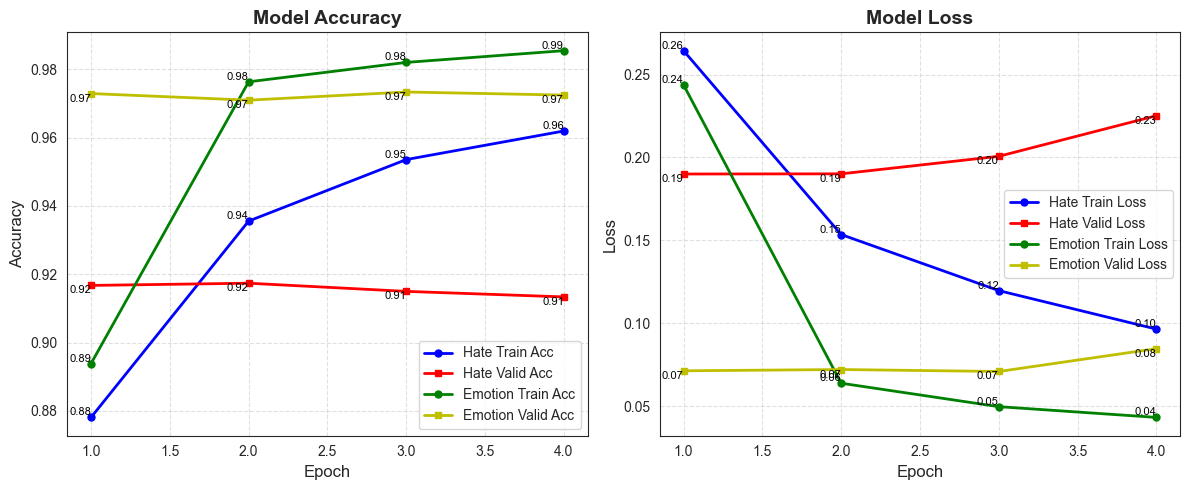

In [64]:
import joblib

history = joblib.load(r"Saved Model Hate/MTL_LSTM_okay/MTL_2_History_balanceTestSet.pkl")

accuracy_hate = history.get('hate_output_accuracy', [])
val_accuracy_hate = history.get('val_hate_output_accuracy', [])
accuracy_emotion = history.get('emotion_output_accuracy', [])
val_accuracy_emotion = history.get('val_emotion_output_accuracy', [])
loss_hate = history.get('hate_output_loss', [])
val_loss_hate = history.get('val_hate_output_loss', [])
loss_emotion = history.get('emotion_output_loss', [])
val_loss_emotion = history.get('val_emotion_output_loss', [])

epochs = range(1, len(accuracy_hate) + 1) 

sns.set_style("white")  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(epochs, accuracy_hate, 'bo-', label='Hate Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_hate, 'rs-', label='Hate Valid Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, accuracy_emotion, 'go-', label='Emotion Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_emotion, 'ys-', label='Emotion Valid Acc', linewidth=2, markersize=5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy_hate)):
    axes[0].text(epochs[i], accuracy_hate[i], f"{accuracy_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_hate[i], f"{val_accuracy_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[0].text(epochs[i], accuracy_emotion[i], f"{accuracy_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_emotion[i], f"{val_accuracy_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

axes[1].plot(epochs, loss_hate, 'bo-', label='Hate Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_hate, 'rs-', label='Hate Valid Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, loss_emotion, 'go-', label='Emotion Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_emotion, 'ys-', label='Emotion Valid Loss', linewidth=2, markersize=5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss_hate)):
    axes[1].text(epochs[i], loss_hate[i], f"{loss_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_hate[i], f"{val_loss_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], loss_emotion[i], f"{loss_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_emotion[i], f"{val_loss_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()



## Trial

In [25]:
import json

file_path = r"./my_dir_MTL/MTL_Hate_Emotion_2/trial_0011/trial.json"

with open(file_path, "r") as f:
    config = json.load(f)

hyperparams = config.get("hyperparameters", {}).get("values", {})
metrics = config.get("metrics", {}).get("metrics", {})

print("📌 Hyperparameters\n")
for key, value in hyperparams.items():
    print(f"- {key}: {value}")

print("\n📊 Training Metrics\n")

def get_metric(metrics, key, default_value="N/A"):
    return metrics.get(key, {}).get("observations", [{}])[0].get("value", [default_value])[0]

train_hate_acc = get_metric(metrics, "hate_output_accuracy")
train_emotion_acc = get_metric(metrics, "emotion_output_accuracy")
train_loss = get_metric(metrics, "loss")
train_hate_loss = get_metric(metrics, "hate_output_loss")
train_emotion_loss = get_metric(metrics, "emotion_output_loss")

val_hate_acc = get_metric(metrics, "val_hate_output_accuracy")
val_emotion_acc = get_metric(metrics, "val_emotion_output_accuracy")
val_loss = get_metric(metrics, "val_loss")
val_hate_loss = get_metric(metrics, "val_hate_output_loss")
val_emotion_loss = get_metric(metrics, "val_emotion_output_loss")

print(f"- Training Hate Accuracy: {train_hate_acc:.4f}")
print(f"- Training Emotion Accuracy: {train_emotion_acc:.4f}")
print(f"- Training Loss: {train_loss:.4f}")
print(f"- Training Hate Loss: {train_hate_loss:.4f}")
print(f"- Training Emotion Loss: {train_emotion_loss:.4f}")

print("\n📊 Validation Metrics\n")
print(f"- Validation Hate Accuracy: {val_hate_acc:.4f}")
print(f"- Validation Emotion Accuracy: {val_emotion_acc:.4f}")
print(f"- Validation Loss: {val_loss:.4f}")
print(f"- Validation Hate Loss: {val_hate_loss:.4f}")
print(f"- Validation Emotion Loss: {val_emotion_loss:.4f}")

print(f"\n🏆 Best Validation Accuracy: {config.get('score', 'N/A'):.4f}")
print(f"📌 Best Step: {config.get('best_step', 'N/A')}")
print(f"✅ Status: {config.get('status', 'N/A')}")


📌 Hyperparameters

- LSTM_Layer_1: 256
- LSTM_Layer_2: 96
- LSTM_Layer_3: 16
- dropout_rate: 0.4
- l2_reg: 0.07100000000000001
- dense_units: 64
- activation: sigmoid
- tuner/epochs: 2
- tuner/initial_epoch: 0
- tuner/bracket: 2
- tuner/round: 0

📊 Training Metrics

- Training Hate Accuracy: 0.7146
- Training Emotion Accuracy: 0.5816
- Training Loss: 1.4947
- Training Hate Loss: 0.5405
- Training Emotion Loss: 0.8120

📊 Validation Metrics

- Validation Hate Accuracy: 0.6068
- Validation Emotion Accuracy: 0.4334
- Validation Loss: 3.1722
- Validation Hate Loss: 1.0535
- Validation Emotion Loss: 1.9788

🏆 Best Validation Accuracy: 0.6068
📌 Best Step: 0
✅ Status: COMPLETED


# EmoHate

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from senticnet.senticnet import SenticNet
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer,roc_auc_score


## Load Data

In [ ]:
# Load Data
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train test Split
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_orig)

# Hate Text (text for get hate speech feature)
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test_orig)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

undersampler = RandomUnderSampler(random_state=42)
dummy_indices = np.arange(len(Y_train)).reshape(-1, 1)
train_indices_resampled, Y_train_resampled = undersampler.fit_resample(dummy_indices, Y_train)
X_train_resampled = X_train_pad[train_indices_resampled.flatten()]
X_train_senticnet_resampled = [X_train_orig[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text) 
    token_indices = tokenizer.texts_to_sequences([tokens])[0] # Convert to index (exp: [4, 10, 7])
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '') # Reverse search for a word based on the index (exp: 4 → "I")
        try:
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass 
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_train_sentic = batch_extract_sentic(X_train_senticnet_resampled, tokenizer, max_len)
x_test_sentic = batch_extract_sentic(X_test_orig, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_train_resampled shape:", X_train_resampled.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("X_test_pad shape:", X_test_pad.shape)
print("Y_test shape:", Y_test.shape)

print("\n=== SenticNet Representation ===")
print("x_train_sentic shape:", x_train_sentic.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("x_test_sentic shape:", x_test_sentic.shape)
print("Y_test shape:", Y_test.shape)


=== Word Embedding Representation ===
X_train_resampled shape: (36126, 100)
Y_train_resampled shape: (36126,)
X_test_pad shape: (24621, 100)
Y_test shape: (24621,)

=== SenticNet Representation ===
x_train_sentic shape: (36126, 100, 24)
Y_train_resampled shape: (36126,)
x_test_sentic shape: (24621, 100, 24)
Y_test shape: (24621,)


## Evaluate

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras")

train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)
y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


## Evaluate 2 - Focal Loss

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55): 
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras",
    custom_objects={'focal_loss_fixed': focal_loss}
)

train_loss, train_accuracy = model.evaluate(
    [X_train_resampled, x_train_sentic], 
    Y_train_resampled,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_pad, x_test_sentic],
    Y_test,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.7888 - loss: 0.0473
770/770 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7870 - loss: 0.0554
770/770 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step

📌 Train Accuracy: 0.8375
📌 Test Accuracy: 0.7871

📌 Weighted F1 Score: 0.7944
📌 Micro F1 Score: 0.7871
📌 Macro F1 Score: 0.7751

📌 Precision: 0.6116
📌 Recall: 0.8846

📌Test ROC AUC: 0.8878

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83     16880
           1       0.61      0.88      0.72      7741

    accuracy                           0.79     24621
   macro avg       0.77      0.81      0.78     24621
weighted avg       0.83      0.79      0.79     24621


📌 Confusion Matrix:
[[12531  4349]
 [  893  6848]]


## Learning Curve

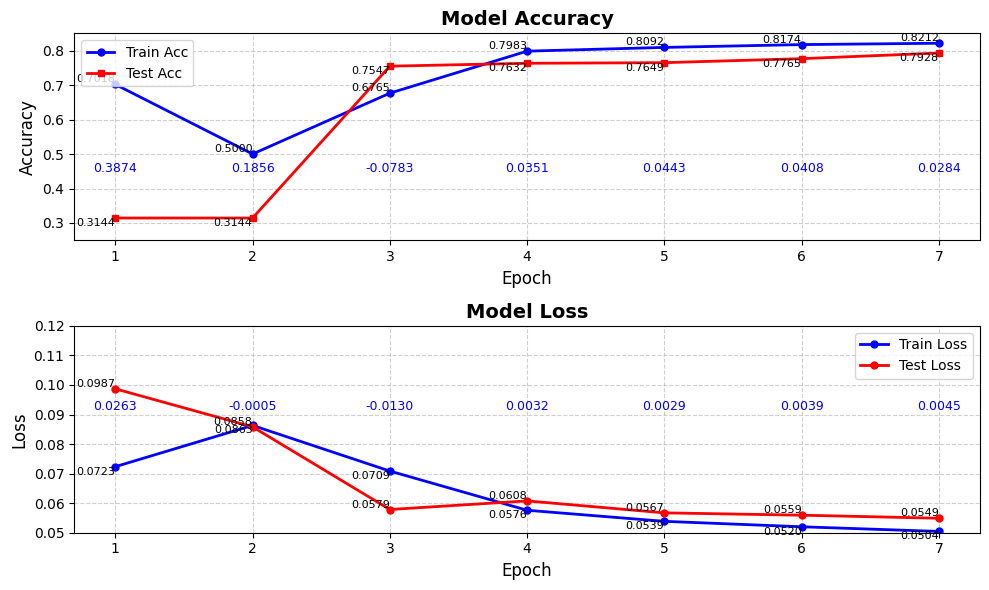

In [23]:
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

history = joblib.load(r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_History.pkl")

accuracy = history.get('accuracy', [])[:7]
val_acc = history.get('val_accuracy', [])[:7]
loss = history.get('loss', [])[:7]
val_loss = history.get('val_loss', [])[:7]


epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.06, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.04, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
axes[0].set_ylim(0.25, 0.85)
axes[1].set_ylim(0.05, 0.12)

plt.tight_layout()
plt.show()




## roc_curve

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55): 
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras",
    custom_objects={'focal_loss_fixed': focal_loss}
)

y_pred_prob = model.predict([X_test_pad, x_test_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.7725


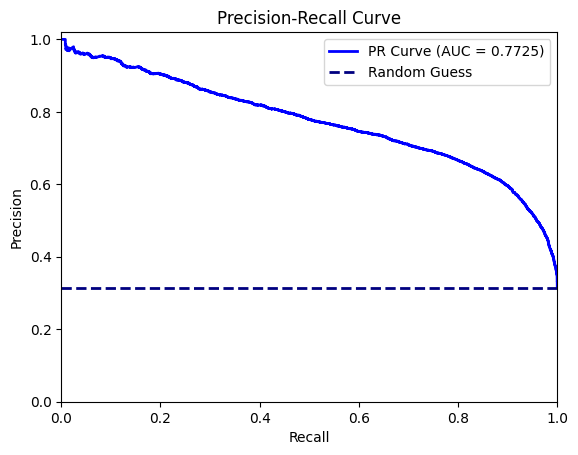

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## confusion_matrix

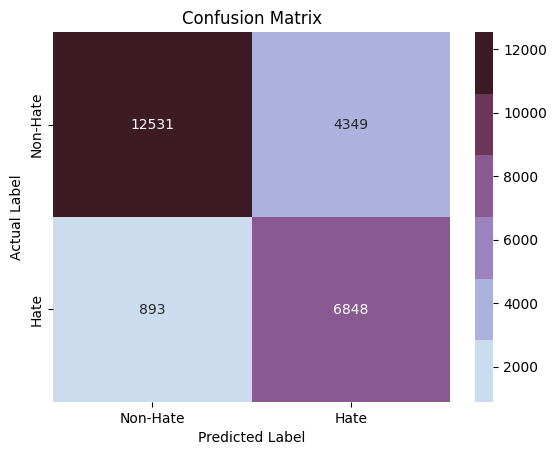

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# Design Dashboard

## Load File

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable


@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)

    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma) 
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras",
    custom_objects={'focal_loss': focal_loss}
)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
import json
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
baseline = sum(y_test) / len(y_test)  

pr_data = {
    "PR_AUC": pr_auc,
    "baseline": baseline,
    "precision": precision.tolist(),
    "recall": recall.tolist()
}

file_path = "Bi-LSTM_PR_Curve.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(pr_data, f, indent=4)

print(f"✅ PR Curve data saved to: {file_path}")


✅ PR Curve data saved to: Bi-LSTM_PR_Curve.json


In [ ]:
import json
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "thresholds": thresholds.tolist(),
    "roc_auc": roc_auc
}
file_path = "Bi-LSTM_ROC_Curve.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(roc_data, f, indent=4)

print(f"✅ ROC Curve data saved to: {file_path}")


✅ ROC Curve data saved to: Bi-LSTM_ROC_Curve.json
